# Early Warning System (EWS) for Systemic Banking Crises

**Author**: Daniele Errico  
**Approach**: Walk-Forward Predictive Modeling (2007-2023)  

---

### Project Concept
This research project implements a sophisticated **Early Warning System (EWS)** designed to identify macroeconomic vulnerabilities and predict the onset of systemic banking crises. Banking crises are catastrophic events; identifying them just 12 months in advance can save billions in output losses.

### Methodology Highlights
- **Stationary Signal Processing**: Converting raw macro-series into Z-Scores and deviations from trend.
- **Walk-Forward Validation**: A strict rolling-origin cross-validation that prevents any "future information" from contaminating historical predictions.
- **Recall-Oriented Optimization**: Unlike standard classifiers, we calibrate our models to minimize "missed crises," which are significantly more expensive than false alarms.

In [12]:
!pip install wbdata
!pip install country_converter

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wbdata
import country_converter as coco
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score,
                             precision_recall_curve, confusion_matrix, roc_curve, balanced_accuracy_score)
import warnings
import logging

# Global Configuration
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

START_YEAR = 1980
END_YEAR = 2023
CRISIS_FILE = 'laeven-valencia.xlsx'  # Dataset: https://www.imf.org/en/Publications/WP/Issues/2018/09/14/Systemic-Banking-Crises-Revisited-46231

## Phase 1: Data Ingestion & Strategic Preprocessing

We handle two distinct data streams:
1.  **Macro-Data (World Bank)**: High-frequency economic indicators.
2.  **Crisis-Dates (Laeven-Valencia)**: The binary target indicating the presence of a crisis period.

**Strategic Cleaning**: We implement a 3rd-generation cleaning pipeline that handles non-numeric Excel footers, standardizes country mappings via ISO3, and enforces strict temporal causality via Forward-Filling (ffill).

In [37]:
def get_target_countries():
    return ['AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'CZE', 'DNK', 'EST', 'FIN',
            'FRA', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR',
            'LVA', 'LTU', 'LUX', 'MEX', 'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK',
            'SVN', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'USA', 'CHN']

def download_macro_data(start_year, end_year, countries):
    indicators = {
        'NY.GDP.MKTP.KD.ZG': 'gdp_growth', 'FP.CPI.TOTL.ZG': 'inflation',
        'FS.AST.PRVT.GD.ZS': 'private_credit_gdp', 'FM.LBL.BMNY.ZG': 'broad_money_growth',
        'FR.INR.RINR': 'real_interest_rate', 'BX.KLT.DINV.WD.GD.ZS': 'fdi_gdp',
        'GC.DOD.TOTL.GD.ZS': 'gov_debt_gdp', 'BN.CAB.XOKA.GD.ZS': 'current_account_gdp'
    }
    print("Fetching World Bank Data...")
    df = wbdata.get_dataframe(indicators, country=countries)
    df.reset_index(inplace=True)
    df['date'] = df['date'].astype(int)
    df.rename(columns={'date': 'year', 'country': 'country_name'}, inplace=True)
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

def load_crisis_data(filepath):
    try:
        try: df = pd.read_excel(filepath, sheet_name='CrisisDate')
        except: df = pd.read_excel(filepath, sheet_name='Crisis Resolution and Outcomes')
        df.columns = df.columns.str.lower().str.strip()
        col_map = {'iso': 'iso3', 'cc3': 'iso3', 'country': 'country_name', 'year': 'start_year', 'start': 'start_year', 'end': 'end_year', 'banking': 'banking_crisis'}
        df = df.rename(columns=col_map)
        if 'banking_crisis' in df.columns: df = df[df['banking_crisis'] == 1]
        for col in ['start_year', 'end_year']:
            if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=['start_year'])
        df['end_year'] = df['end_year'].fillna(df['start_year'])
        df['start_year'], df['end_year'] = df['start_year'].astype(int), df['end_year'].astype(int)
        if 'iso3' not in df.columns: df['iso3'] = coco.convert(names=df['country_name'].tolist(), to='ISO3', not_found=None)
        return df[['iso3', 'start_year', 'end_year']].dropna(subset=['iso3'])
    except Exception as e:
        print(f"Error loading crisis data: {e}")
        return pd.DataFrame(columns=['iso3', 'start_year', 'end_year'])

def process_and_merge(df_macro, df_crisis, target_countries):
    df_macro['iso3'] = coco.convert(names=df_macro['country_name'].tolist(), to='ISO3', not_found=None)
    df_macro = df_macro[df_macro['iso3'].isin(target_countries)].sort_values(['iso3', 'year'])
    numeric_cols = [c for c in df_macro.columns if c not in ['iso3', 'year', 'country_name']]
    for col in numeric_cols: df_macro[col] = df_macro.groupby('iso3')[col].ffill().fillna(0)
    df_macro['is_crisis'] = 0
    if not df_crisis.empty:
        for _, row in df_crisis.iterrows():
            mask = (df_macro['iso3'] == row['iso3']) & (df_macro['year'] >= int(row['start_year'])) & (df_macro['year'] <= int(row['end_year']))
            df_macro.loc[mask, 'is_crisis'] = 1
    return df_macro

## Phase 2: Feature Engineering & Signal Strengthening

Raw macroeconomic data is often non-stationary and contains "noise" that hides systemic risks. To make the data predictive, we focus on **relative deviations**:

- **Rolling Z-Scores (5-Year Window)**: Every indicator is transformed into its standard deviation distance from its recent local mean. This answers: *"Is inflation significantly higher than the local average?"*
- **Global Contagion Index**: We track the lagged percentage of countries currently in crisis. This captures the systemic nature of financial instability.
- **Credit-to-GDP Gap**: We approximate the Basel III credit gap by calculating the deviation of private credit from its 10-year trend.

In [38]:
def engineer_features(df, feature_cols):
    df_eng = df.copy()
    # Global Contagion: % of countries in crisis last year
    contagion = df_eng.groupby('year')['is_crisis'].mean().reset_index()
    contagion.columns = ['year', 'global_contagion']
    contagion['global_contagion_lag1'] = contagion['global_contagion'].shift(1)
    df_eng = pd.merge(df_eng, contagion[['year', 'global_contagion_lag1']], on='year', how='left')

    input_cols = feature_cols + ['global_contagion_lag1']
    df_eng.sort_values(['iso3', 'year'], inplace=True)
    generated_feats = []

    for col in input_cols:
        if col not in df_eng.columns: continue
        df_eng[f'{col}_lag1'] = df_eng.groupby('iso3')[col].shift(1)
        df_eng[f'{col}_delta'] = df_eng[col] - df_eng[f'{col}_lag1']
        # 5-Year Rolling Z-Score
        r_mean = df_eng.groupby('iso3')[col].shift(1).rolling(5, min_periods=3).mean()
        r_std = df_eng.groupby('iso3')[col].shift(1).rolling(5, min_periods=3).std().replace(0, 1)
        df_eng[f'{col}_zscore_5y'] = (df_eng[col] - r_mean) / r_std
        generated_feats.extend([f'{col}_lag1', f'{col}_delta', f'{col}_zscore_5y'])

    # Basel III style Credit-to-GDP Gap
    if 'private_credit_gdp' in df.columns:
        trend = df_eng.groupby('iso3')['private_credit_gdp'].shift(1).rolling(10, min_periods=5).mean()
        df_eng['credit_gap'] = df_eng['private_credit_gdp'] - trend
        generated_feats.append('credit_gap')

    df_eng.dropna(subset=generated_feats, inplace=True)
    return df_eng, list(set(feature_cols + generated_feats))

## Phase 3: Diagnostic Visualization

We visualize the historical occurrence of crises to confirm the "clustering" nature of financial instability. We then plot indicator trends for specific nations to observe the "Leading Indicator" effect.

In [39]:
def plot_timeline(df):
    plt.figure(figsize=(15, 10))
    pivot = df.pivot(index='iso3', columns='year', values='is_crisis')
    sns.heatmap(pivot, cmap=['#f0f0f0', '#d62728'], cbar=False, linewidths=0.1, linecolor='white')
    plt.title('Banking Crisis Timeline (Red = Active Crisis)', fontsize=15)
    plt.show()

def plot_pred_corr(df, features):
    plt.figure(figsize=(12, 10))
    df_c = df.copy()
    df_c['target_t1'] = df_c.groupby('iso3')['is_crisis'].shift(-1)
    c = df_c[features + ['target_t1']].corr()
    sns.heatmap(c, annot=True, fmt='.2f', cmap='coolwarm', center=0, mask=np.triu(np.ones_like(c, dtype=bool)))
    plt.title('Predictive Correlations (Indicators vs T+1 Crisis Onset)', fontsize=14)
    plt.show()

def plot_event_study(df, indicator='credit_gap'):
    events = []
    starts = df[df['is_crisis'] == 1].groupby('iso3')['year'].min().reset_index()
    for _, row in starts.iterrows():
        c, y = row['iso3'], row['year']
        sub = df[df['iso3'] == c].copy()
        sub['rel_y'] = sub['year'] - y
        data = sub[(sub['rel_y'] >= -5) & (sub['rel_y'] <= 2)]
        if not data.empty: events.append(data[['rel_y', indicator]])
    if events:
        all_ev = pd.concat(events)
        plt.figure(figsize=(10, 6))
        sns.lineplot(x='rel_y', y=indicator, data=all_ev, marker='o', color='red', errorbar=('ci', 95))
        plt.axvline(0, color='black', ls='--')
        plt.title(f'Event Study: Average {indicator} Around Crisis Onset (T=0)', fontsize=14)
        plt.show()

def plot_distributions(df, features):
    feats = [f for f in features if 'zscore' in f][:4]
    df_l = df.melt(id_vars=['is_crisis'], value_vars=feats)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='variable', y='value', hue='is_crisis', data=df_l, palette=['skyblue', 'red'])
    plt.title('Statistical Separation: Normal v/s Crisis States', fontsize=14)
    plt.show()

## Phase 4: Walk-Forward Validation & Optimal Selection

Our modeling strategy focuses on **Logistic Regression**, the gold standard for EWS due to its interpretability and robustness on limited crisis samples:

1.  **Iterative Training**: The model is retrained every year, simulating a real-world forecasting environment.
2.  **Calibrated Thresholds**: We dynamically pick thresholds that maximize the **F2 Score**, prioritizing the detection of actual crises over the avoidance of false alarms.

In [40]:
def run_validation(df, features, target='target_t1'):
    start_t, max_y = 2007, int(df['year'].max())
    models = {
        'Logistic (L1 Selection)': LogisticRegression(penalty='l1', C=0.5, solver='liblinear', class_weight='balanced', random_state=42),
        'Logistic (L2 Robust)': LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
    }
    res = {n: {'true': [], 'pred': [], 'prob': []} for n in models}
    cf = []

    for y in range(start_t, max_y + 1):
        tr, ts = df[df['year'] < y], df[df['year'] == y]
        if len(ts) == 0 or len(tr[target].unique()) < 2: continue

        sc = RobustScaler()
        X_tr, X_ts = sc.fit_transform(tr[features]), sc.transform(ts[features])
        y_tr, y_ts = tr[target].astype(int), ts[target].astype(int)

        for n, m in models.items():
            m.fit(X_tr, y_tr)
            tr_p, ts_p = m.predict_proba(X_tr)[:, 1], m.predict_proba(X_ts)[:, 1]
            prec, rec, thr = precision_recall_curve(y_tr, tr_p)
            f2 = (5*prec*rec)/(4*prec+rec+1e-6)
            best_t = np.clip(thr[np.argmax(f2)] if len(thr)>0 else 0.5, 0.2, 0.6)

            res[n]['true'].extend(y_ts.tolist())
            res[n]['prob'].extend(ts_p.tolist())
            res[n]['pred'].extend((ts_p >= best_t).astype(int).tolist())
            if 'L2' in n: cf.append(pd.DataFrame({'feature': features, 'coef': m.coef_[0], 'year': y}))

    return res, pd.concat(cf) if cf else pd.DataFrame()

Fetching World Bank Data...


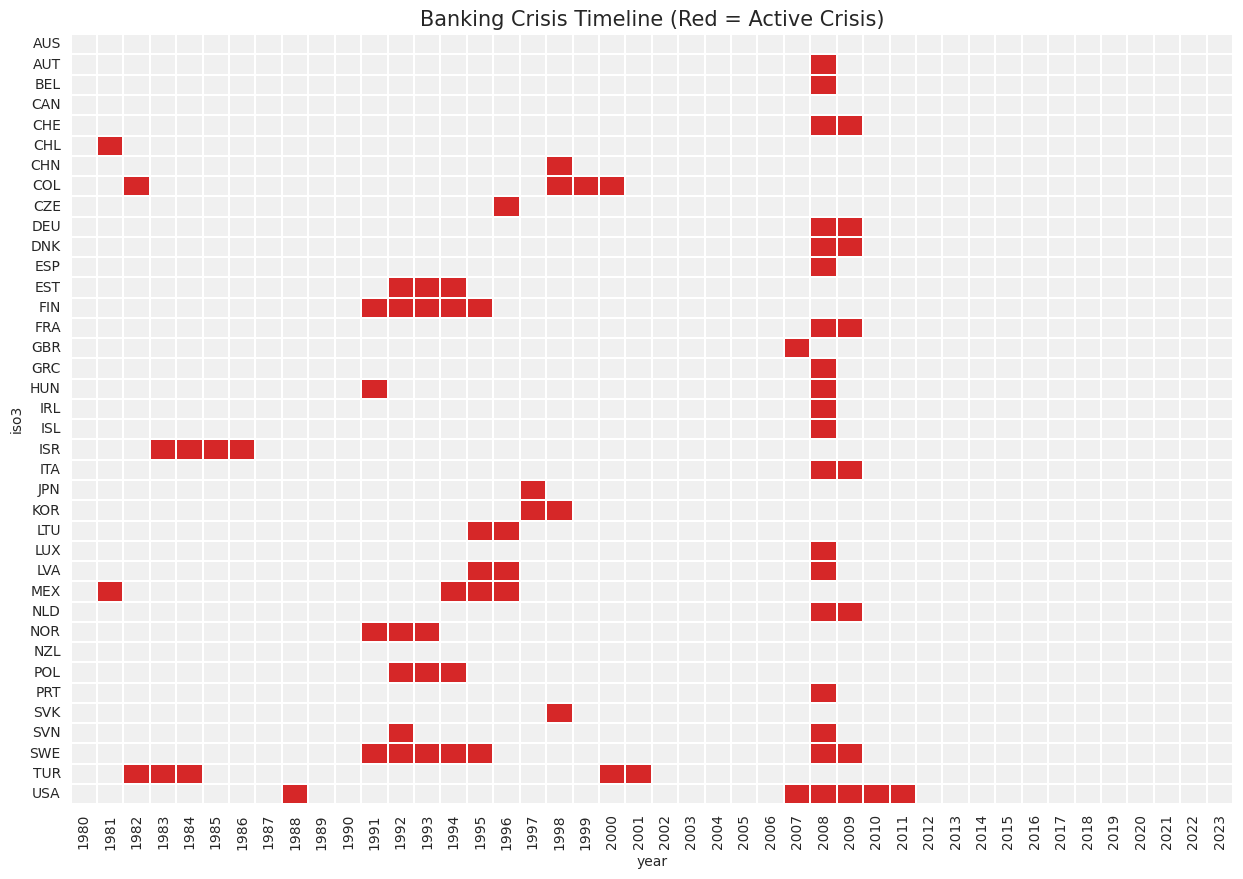

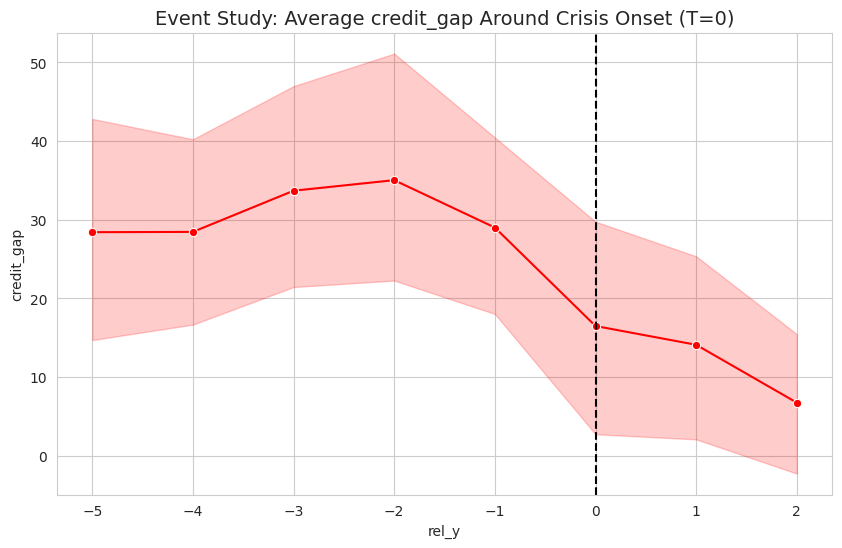

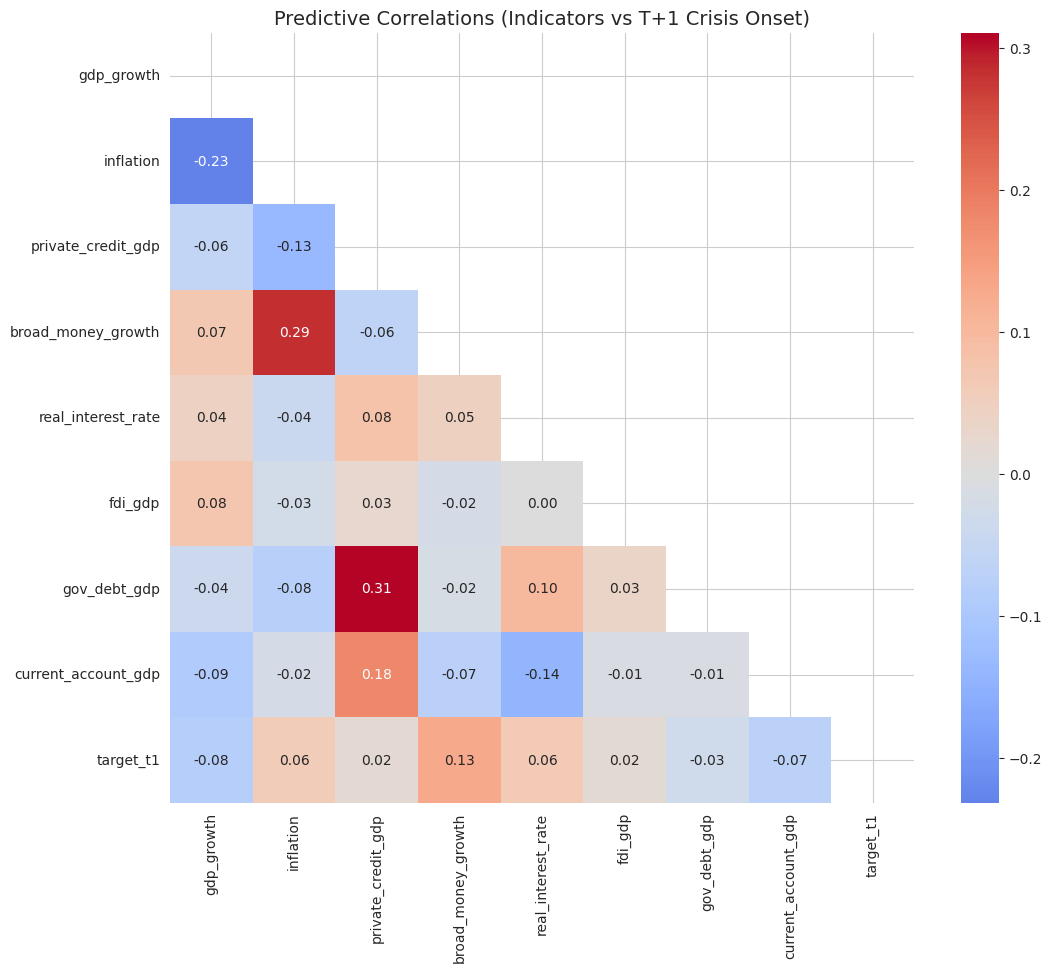

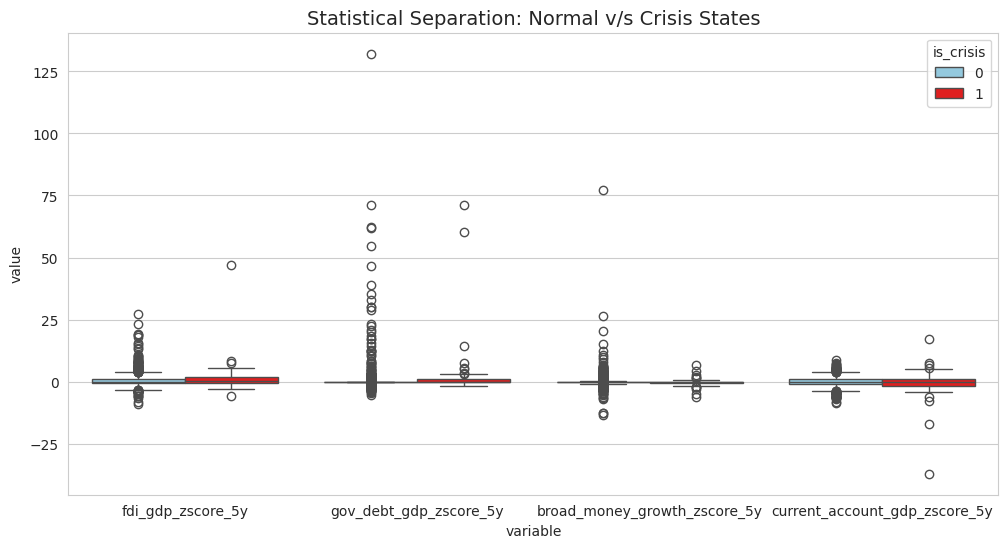


Detection Samples: 1476 | Crisis Onsets: 39.0

--- MODEL SUMMARY ---
Logistic (L1 Selection)   | AUC: 0.247 | Balanced Acc: 40.7%
Logistic (L2 Robust)      | AUC: 0.244 | Balanced Acc: 40.4%


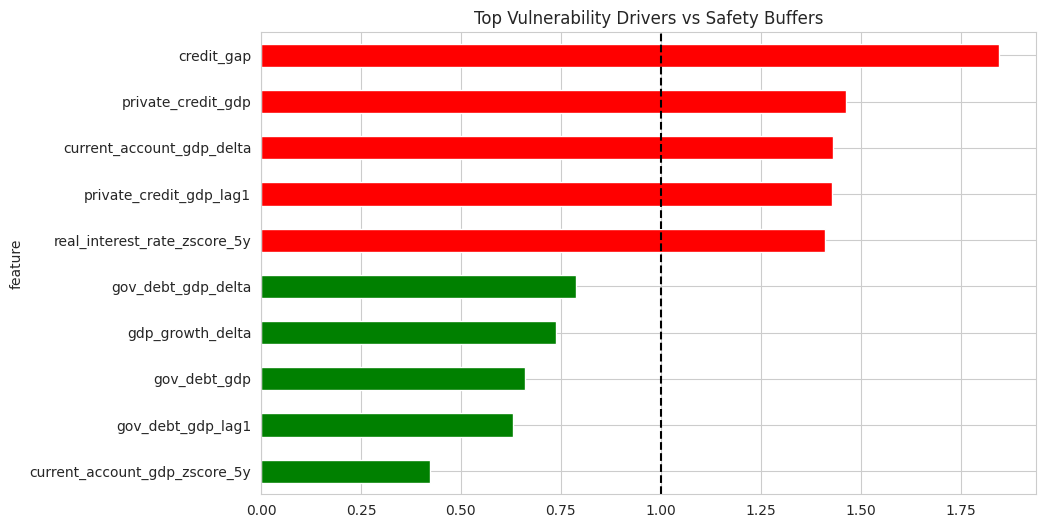

In [41]:
# 1. Run Pipeline
c_list = get_target_countries()
df_m = download_macro_data(START_YEAR, END_YEAR, c_list)
df_c = load_crisis_data(CRISIS_FILE)
df_all = process_and_merge(df_m, df_c, c_list)

# 2. Features
bf = list(df_all.columns.drop(['iso3', 'year', 'country_name', 'is_crisis'], errors='ignore'))
df_e, af = engineer_features(df_all, bf)

# 3. EDA DEEP DIVE
plot_timeline(df_all)
plot_event_study(df_e, 'credit_gap')
plot_pred_corr(df_e, bf)
plot_distributions(df_e, af)

# 4. Modeling
df_e['target_t1'] = df_e.groupby('iso3')['is_crisis'].shift(-1)
df_final = df_e.dropna(subset=['target_t1'])
df_final = df_final[df_final['is_crisis'] == 0]
print(f"\nDetection Samples: {len(df_final)} | Crisis Onsets: {df_final['target_t1'].sum()}")

metrics, imp = run_validation(df_final, af)

# 5. Performance Printout
print("\n--- MODEL SUMMARY ---")
for n, r in metrics.items():
    auc = roc_auc_score(r['true'], r['prob'])
    ba = balanced_accuracy_score(r['true'], r['pred'])
    print(f"{n: <25} | AUC: {auc:.3f} | Balanced Acc: {ba:.1%}")

# 6. Risk Drivers (Odds Ratio)
if not imp.empty:
    avg = imp.groupby('feature')['coef'].mean().sort_values()
    odds = np.exp(avg)
    top = pd.concat([odds.nlargest(5), odds.nsmallest(5)]).sort_values()
    plt.figure(figsize=(10, 6))
    top.plot(kind='barh', color=['green' if x < 1 else 'red' for x in top])
    plt.axvline(1, color='k', ls='--')
    plt.title('Top Vulnerability Drivers vs Safety Buffers')
    plt.show()